In [1]:
import numpy as np
from DataLoader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imshow
from sklearn.cluster import KMeans
from string import ascii_lowercase

In [2]:
%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize':(13,8.27)})

In [4]:
def create_color_features(data):
    data['Red'] = data['image'].map(lambda x: np.mean(x[:,:,0]))
    data['Green'] = data['image'].map(lambda x: np.mean(x[:,:,1]))
    data['Blue'] = data['image'].map(lambda x: np.mean(x[:,:,2]))
    data['Gray'] = data['image'].map(lambda x: np.mean(x))
    data['Red-Green'] = data['image'].map(lambda x: np.mean(x[:,:,0]-x[:,:,1]))
    data['Red-Green-Sd'] = data['image'].map(lambda x: np.std(x[:,:,0]-x[:,:,1]))
    return data

In [5]:
def create_color_cluster(data, cluster_maker = None, cluster_count = 3):
    if cluster_maker is None:
        cluster_maker = KMeans(cluster_count)
        cluster_maker.fit(data[['Green', 'Red-Green', 'Red-Green-Sd']])
        
    data['cluster-id'] = np.argmin(
        cluster_maker.transform(data[['Green', 'Red-Green', 'Red-Green-Sd']]),
        -1)
    data['cluster-id'] = data['cluster-id'].map(lambda x: ascii_lowercase[x])
    return data, cluster_maker


In [6]:
# load data
data = DataLoader("data/train", "data/test")
train_images, masks = data.load_train_data()
test_images = data.load_test_data(False)

In [7]:
# Convert to pandas dataframe
train_images_pd, masks_pd = pd.DataFrame(train_images, columns=['image']), pd.DataFrame(masks, columns=['mask'])
test_images_pd = pd.DataFrame(test_images, columns=['image']) 

In [8]:
# Origin of each image
train_images_pd['origin'] = "train"
test_images_pd['origin'] = "test"

In [9]:
# Concat to one dataframe
all_images_pd = pd.concat([train_images_pd, test_images_pd])

In [10]:
# Create column of shape
train_images_pd['shape'] = train_images_pd['image'].apply(lambda image: image.shape)
test_images_pd['shape'] = test_images_pd['image'].apply(lambda image: image.shape)

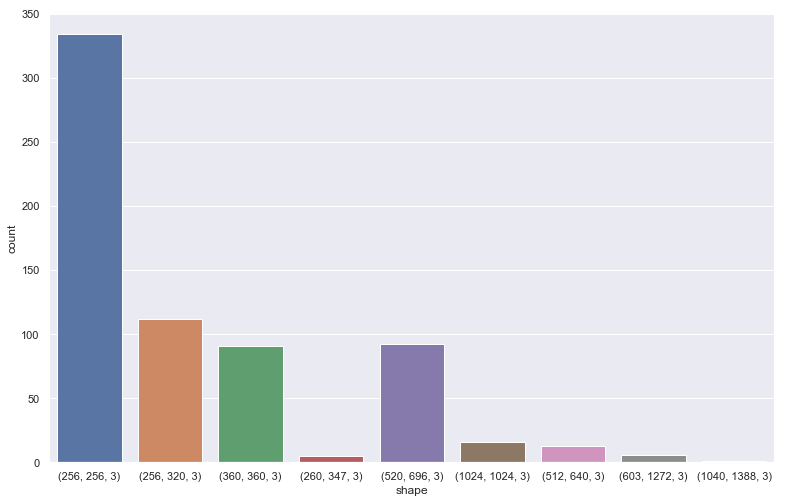

In [11]:
# Countplot of shapes
sns.countplot(x = "shape", data=train_images_pd)

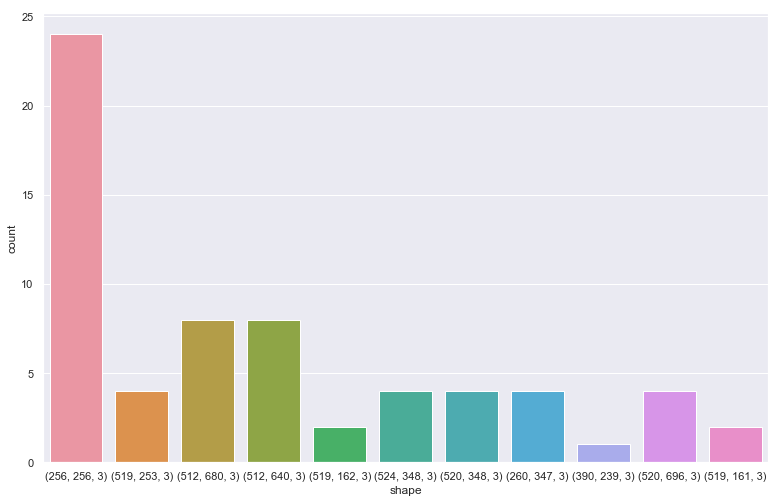

In [12]:
sns.countplot(x = "shape", data=test_images_pd)

In [13]:
color_features_names = ['Gray', 'Red', 'Green', 'Blue', 'Red-Green',  'Red-Green-Sd']

In [14]:
all_images_pd = create_color_features(all_images_pd)

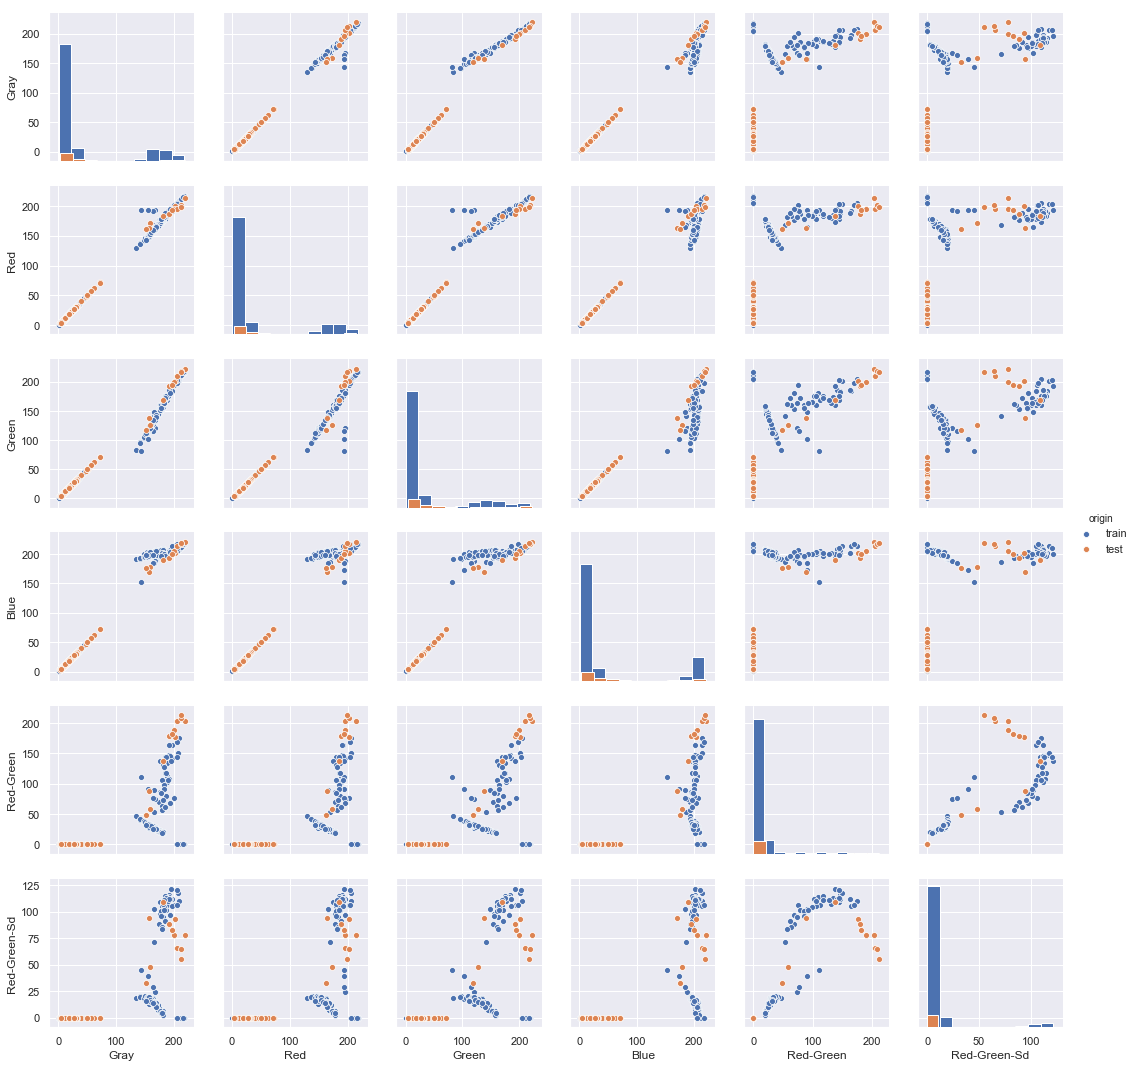

In [15]:
sns.pairplot(all_images_pd[color_features_names+['origin']], 
             hue = 'origin', diag_kind="hist")

In [16]:
all_images_pd, train_cluster_maker = create_color_cluster(all_images_pd, cluster_count=4)

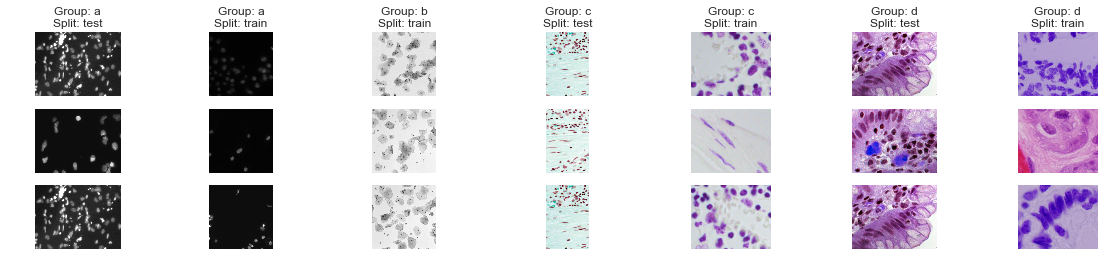

In [17]:
n_img = 3
grouper = all_images_pd.groupby(['cluster-id', 'origin'])
fig, m_axs = plt.subplots(n_img, len(grouper), 
                          figsize = (20, 4))
for (c_group, clus_group), c_ims in zip(grouper, 
                                     m_axs.T):
    c_ims[0].set_title('Group: {}\nSplit: {}'.format(*c_group))
    for (_, clus_row), c_im in zip(clus_group.sample(n_img, replace = True).iterrows(), c_ims):
        c_im.imshow(clus_row['image'])
        c_im.axis('off')

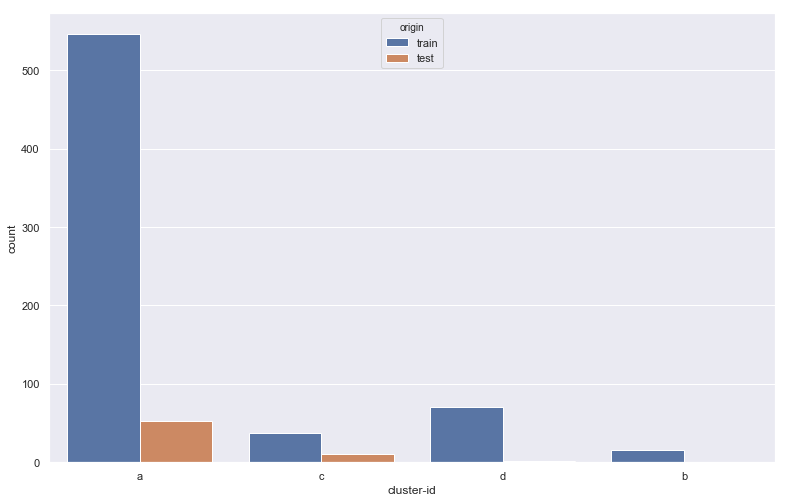

In [18]:
sns.countplot(x = "cluster-id", data = all_images_pd, hue = "origin")